In [ ]:
from env_function import environmental_variables
import matplotlib.pyplot as plt

bbox = (-83.0, 27.3, -82.4, 28.0)

env = environmental_variables(
    bbox,
    "2019-01-01",
    "2024-12-31",
    variables=["sst", "precip"]
)



In [3]:
# ======================================================================
# BLOCK 1: Setup, Dask Initialization, and Data Retrieval (Modular Limit 100)
# ======================================================================

# 1. Imports
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from dask.distributed import Client, LocalCluster, config
import warnings
import atexit 

# Make sure your env_function.py is the modular version!
from env_function import environmental_variables 

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# ----------------------------------------------------------------------
# 2. Start Dask Cluster for Parallel Processing (With RETRIES AND TIMEOUTS)
# ----------------------------------------------------------------------

# Configure Dask for robust retries
config["distributed.scheduler.unknown-handler-retry-delay"] = 1.0
config["distributed.retries"] = 5  
config["fsspec"] = {"timeout": 60} # Increased network timeout

print("Starting Dask Local Cluster with 5 retries and 60s timeout...")
client = None
cluster = None

try:
    cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit='8GB') # Increased memory_limit
    client = Client(cluster)
    
    atexit.register(client.close)
    atexit.register(cluster.close)
    
    print(f"Dask Dashboard link: {client.dashboard_link}")
    print(f"Dask Workers: {len(client.scheduler_info()['workers'])}")
    
except Exception as e:
    print(f"Could not start Dask client: {e}")

# ----------------------------------------------------------------------
# 3. Define Parameters
# ----------------------------------------------------------------------

bbox_new = (-82.7, 27.6, -82.3, 28.0) 
start_date = "2019-01-01"
end_date = "2024-12-31" 

# --- FIX: Define the item limit here in the notebook (REDUCED TO 100) ---
PRECIP_ITEM_LIMIT = 100 

# ----------------------------------------------------------------------
# 4. Call the Environmental Data Function and Load Data
# ----------------------------------------------------------------------

sst_ts = None
precip_ts = None

if client:
    print("\n--- Starting Data Retrieval ---")
    print(f"Fetching data for BBox: {bbox_new}")
    print(f"Time Range: {start_date} to {end_date}")

    # Calling the function with the new modular item limit argument
    env_data = environmental_variables(
        bbox_new, 
        start_date,
        end_date,
        variables=["sst", "precip"],
        max_items=PRECIP_ITEM_LIMIT # <--- Passing the reduced limit here
    )

    sst_ts = env_data.get("sst")
    precip_ts = env_data.get("precip")

    print("\n--- Data Retrieval Complete ---")
else:
    print("\nSkipping data retrieval because Dask client failed to start.")

Starting Dask Local Cluster with 5 retries and 60s timeout...
Dask Dashboard link: http://127.0.0.1:45283/status
Dask Workers: 4

--- Starting Data Retrieval ---
Fetching data for BBox: (-82.7, 27.6, -82.3, 28.0)
Time Range: 2019-01-01 to 2024-12-31

Accessing SST Zarr store on AWS S3: s3://surftemp-sst/data/sst.zarr
✔ SST months loaded: 24

Fetching Precipitation (NOAA MRMS QPE 24h) via Batched STAC Search (Strict Limit: 100 items)...
  Found 0 items for 2019. Added 0. Total: 0
  Found 278 items for 2020. Added 100. Total: 100
  Strict item limit reached. Skipping remaining years.
Total precip items used for computation: 100
✔ Precip loaded: 2 months

Aligning and merging datasets...
✔ Merged months: 2

--- Data Retrieval Complete ---


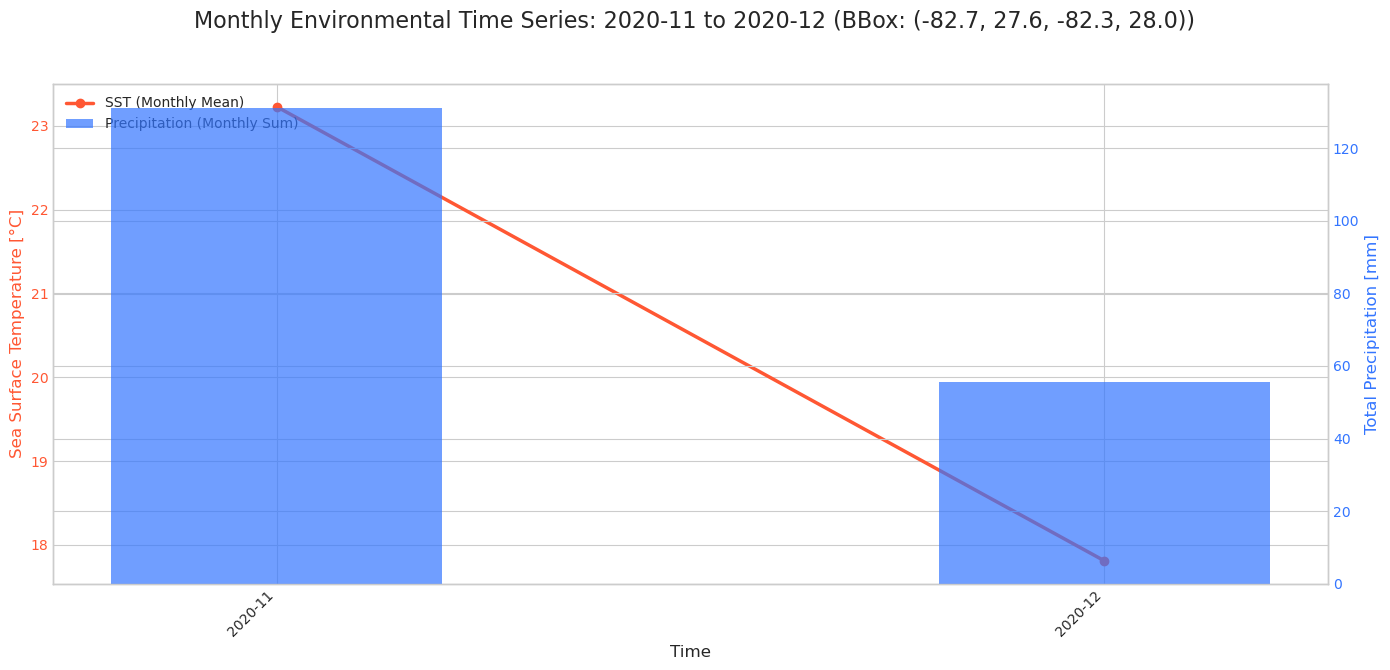


Shutting down Dask cluster.


Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x752f0409b050>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7719da669110>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x77a8f4f94350>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7fe8c8e7b810>


In [4]:
# ======================================================================
# BLOCK 2: Plotting and Dask Cleanup (SIMPLIFIED X-AXIS FIX)
# ======================================================================

# Note: This block relies on 'sst_ts', 'precip_ts', and 'client' from Block 1.

# ----------------------------------------------------------------------
# 5. Plot the Time Series Data
# ----------------------------------------------------------------------

if sst_ts is not None and precip_ts is not None:
    plt.style.use('seaborn-v0_8-whitegrid') 

    # 1. Create the figure and main axis (ax1)
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    # Use the 'merged months' size for the title range
    time_start = sst_ts.time.min().dt.strftime('%Y-%m').item()
    time_end = sst_ts.time.max().dt.strftime('%Y-%m').item()
    
    fig.suptitle(
        f'Monthly Environmental Time Series: {time_start} to {time_end} (BBox: {bbox_new})', 
        fontsize=16
    )

    # 2. Plot SST on the primary Y-axis (ax1)
    # Convert time to datetime objects for reliable plotting
    time_points = sst_ts.time.dt.strftime('%Y-%m').to_numpy()
    
    ax1.plot(time_points, sst_ts.to_numpy(), color='#FF5733', linewidth=2.5, marker='o', label='SST (Monthly Mean)', zorder=2)
    ax1.set_ylabel('Sea Surface Temperature [°C]', color='#FF5733', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='#FF5733')
    ax1.set_xlabel('Time', fontsize=12)
    ax1.set_title('') 

    # 3. Plot Precipitation on the secondary Y-axis (ax2)
    ax2 = ax1.twinx()  
    
    # Use the same time points for alignment, but plot as a bar chart
    bar_plot = ax2.bar(
        time_points, 
        precip_ts.to_numpy(), 
        width=0.4, # Adjusted width to clearly show discrete bars
        color='#3375FF', 
        alpha=0.7,
        label='Precipitation (Monthly Sum)',
        zorder=1 
    )
    
    ax2.set_ylabel('Total Precipitation [mm]', color='#3375FF', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='#3375FF')
    
    # 4. Format the X-Axis
    # Force the X-axis to display all labels, centered on the bar/point
    ax1.set_xticks(time_points)
    ax1.set_xticklabels(time_points, rotation=45, ha='right', fontsize=10)
    
    # 5. Add a legend
    line_handles, line_labels = ax1.get_legend_handles_labels()
    bar_handle = [bar_plot]
    bar_label = ['Precipitation (Monthly Sum)']

    ax1.legend(line_handles + bar_handle, line_labels + bar_label, loc='upper left')

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

else:
    print("\nCould not generate plot because one or both datasets failed to load.")
    if sst_ts is not None: print(f"SST size: {sst_ts.time.size} months")
    if precip_ts is not None: print(f"Precipitation size: {precip_ts.time.size} months")


# ----------------------------------------------------------------------
# 6. Stop Dask Cluster
# ----------------------------------------------------------------------
if client and not client.status == 'closed':
    print("\nShutting down Dask cluster.")
    client.close()
    if cluster:
        cluster.close()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

print(" Loading SST + MRMS...")

env = environmental_variables(bbox=bbox, start_date=start, end_date=end)

sst = env.get("sst")
precip = env.get("precip")

# -------------------------
# 1. SST → pandas
# -------------------------
df_sst = pd.DataFrame({
    "time": pd.to_datetime(sst.time.values),
    "sst": sst.values
})

# -------------------------
# 2. MRMS → convert to pandas BEFORE grouping
# -------------------------
if precip is None:
    print(" MRMS has no data — creating empty precip column.")
    df_precip = pd.DataFrame({"time": df_sst["time"], "precip": float("nan")})

else:
    print(" Converting MRMS DataArray → pandas...")

    df_precip_raw = pd.DataFrame({
        "time": pd.to_datetime(precip.time.values),
        "precip": precip.values
    })

    print(" Collapsing MRMS to daily means...")
    df_precip = df_precip_raw.groupby(df_precip_raw["time"].dt.floor("D")).mean().reset_index()


# -------------------------
# 3. Merge SST + MRMS
# -------------------------
df_merged = df_sst.merge(df_precip, on="time", how="left")

print("\n FIRST ROWS:")
print(df_merged.head())


# -------------------------
# 4. Plot
# -------------------------
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(df_merged["time"], df_merged["sst"], linewidth=2)
ax1.set_ylabel("SST (°C)")

ax2 = ax1.twinx()
ax2.plot(df_merged["time"], df_merged["precip"], linestyle="--")
ax2.set_ylabel("Precip (mm/day)")

plt.title("Daily SST + MRMS Precipitation")
plt.tight_layout()
plt.show()

print("✔ DONE")


In [ ]:
# cell one 
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from env_function import environmental_variables
import analysis  # your new module

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 4)

bbox = (-83.0, 27.3, -82.4, 28.0)
start = "2019-01-01"
end   = "2024-12-31"

env = environmental_variables(bbox, start, end, ["sst", "precip"])
sst = env["sst"]
precip = env["precip"]

# from Grace's code:
# ndwi_daily, ndci_daily, ndti_daily already computed for same bbox and dates


In [ ]:
# Cell 2: monthly and seasonal means using analysis.py

sst_aggr    = analysis.compute_monthly_seasonal_means(sst)
precip_aggr = analysis.compute_monthly_seasonal_means(precip)
ndwi_aggr   = analysis.compute_monthly_seasonal_means(ndwi_daily)
ndci_aggr   = analysis.compute_monthly_seasonal_means(ndci_daily)
ndti_aggr   = analysis.compute_monthly_seasonal_means(ndti_daily)

sst_monthly    = sst_aggr["monthly"]
precip_monthly = precip_aggr["monthly"]
ndwi_monthly   = ndwi_aggr["monthly"]
ndci_monthly   = ndci_aggr["monthly"]
ndti_monthly   = ndti_aggr["monthly"]

sst_season    = sst_aggr["seasonal"]
precip_season = precip_aggr["seasonal"]
ndwi_season   = ndwi_aggr["seasonal"]
ndci_season   = ndci_aggr["seasonal"]
ndti_season   = ndti_aggr["seasonal"]


In [ ]:
# Cell 3: time-series and seasonal-cycle plots

analysis.plot_time_series(sst_monthly,    "SST (°C)")
analysis.plot_time_series(precip_monthly, "Precipitation (mm/day)")
analysis.plot_time_series(ndci_monthly,   "NDCI")

analysis.plot_seasonal_cycle(ndci_daily,  "NDCI")
analysis.plot_seasonal_cycle(precip,      "Precipitation")


In [ ]:
# Cell 4: build monthly DataFrames and compute correlation matrix

wqi_df = xr.Dataset({
    "NDWI": ndwi_monthly,
    "NDCI": ndci_monthly,
    "NDTI": ndti_monthly,
}).to_dataframe()

env_df = xr.Dataset({
    "SST":   sst_monthly,
    "PRECT": precip_monthly,
}).to_dataframe()

corr_matrix = analysis.compute_correlation_matrix(wqi_df, env_df)
corr_matrix


In [ ]:
# Cell 5: RMSE examples

rmse_ndci_sst   = analysis.compute_rmse(ndci_monthly.values, sst_monthly.values)
rmse_ndci_prect = analysis.compute_rmse(ndci_monthly.values, precip_monthly.values)
rmse_ndti_sst   = analysis.compute_rmse(ndti_monthly.values, sst_monthly.values)
rmse_ndti_prect = analysis.compute_rmse(ndti_monthly.values, precip_monthly.values)

print("RMSE NDCI–SST:   ", rmse_ndci_sst)
print("RMSE NDCI–PRECT: ", rmse_ndci_prect)
print("RMSE NDTI–SST:   ", rmse_ndti_sst)
print("RMSE NDTI–PRECT: ", rmse_ndti_prect)


In [ ]:
# Cell 6: PCA on combined monthly indices + environmental variables

pca_results = analysis.compute_pca(wqi_df, env_df, n_components=2)
loadings = pca_results["loadings"]
loadings


In [ ]:
# Cell 6b: visualize PCA loadings

analysis.plot_pca_results(loadings)
